In [1]:
# Scientific libraries
import numpy_html
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"


from pyipn import copy_template, Universe

In [62]:
def time_filter(time, start, stop, strength):
    
    
    
    return sf.expit( strength*(time-start)  ) * (1 -sf.expit( strength*(time- stop)  ) )
    

<IPython.core.display.Javascript object>


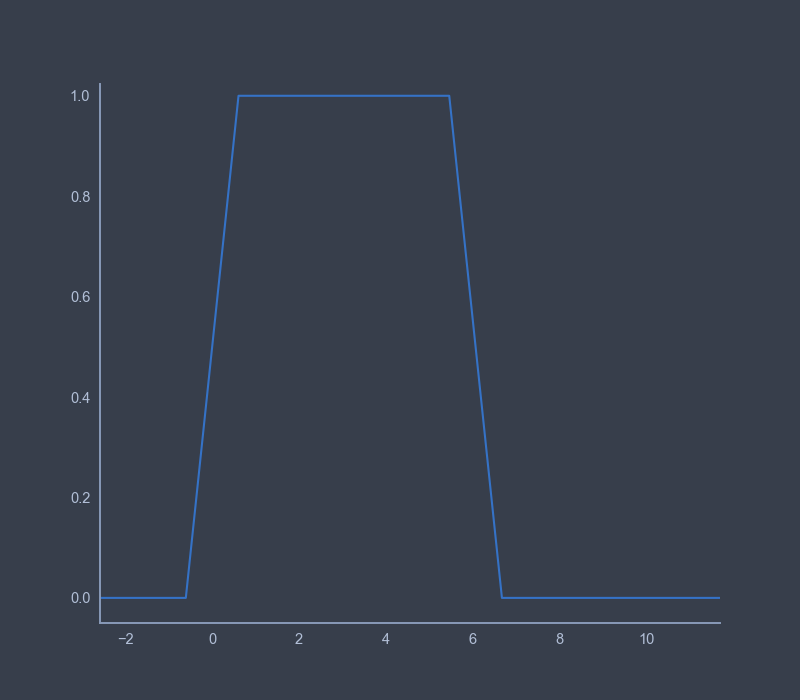

In [67]:
fig, ax = plt.subplots()


xx = np.linspace(-20,100,100)



y = time_filter(xx, 0, 6, 100)


ax.plot(xx, y)


In [2]:
#copy_template()

<IPython.core.display.Javascript object>


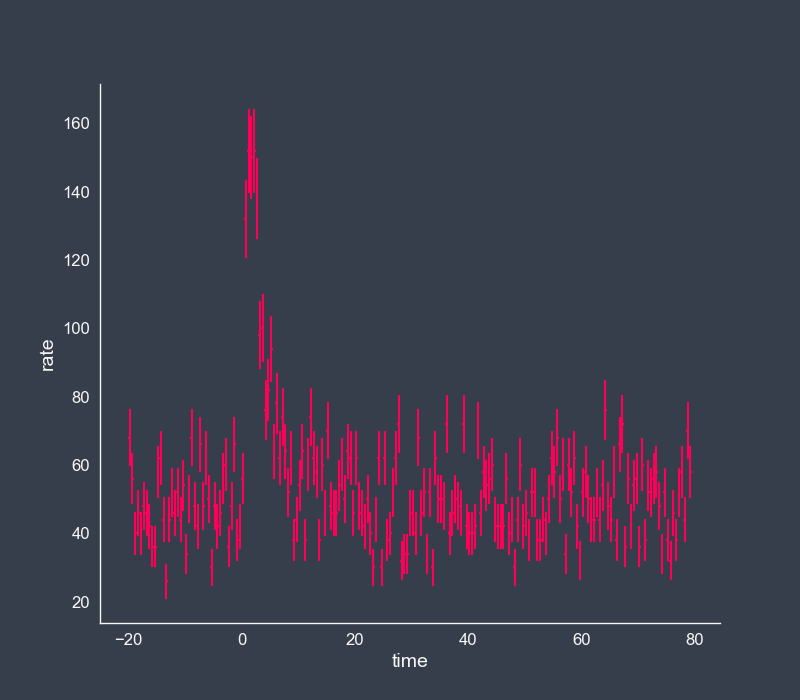

<IPython.core.display.Javascript object>


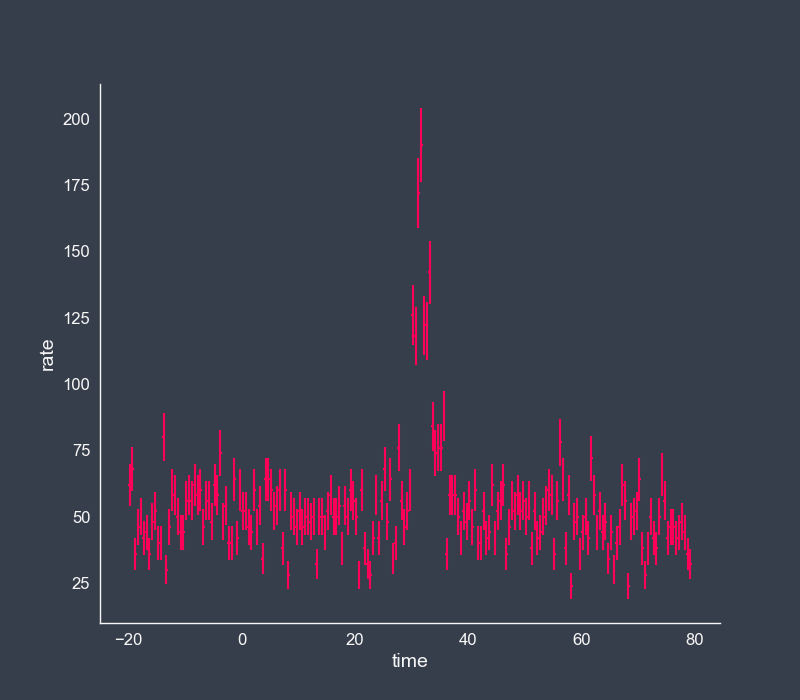

In [5]:
with plt.style.context('mike_dark'):

    uni = Universe.from_yaml('template_config.yaml')
    uni.explode_grb(tstart=-50,tstop=100)
    for det, lc in uni.light_curves.items():

        lc.display(-20,80,.5,color=red)



<IPython.core.display.Javascript object>


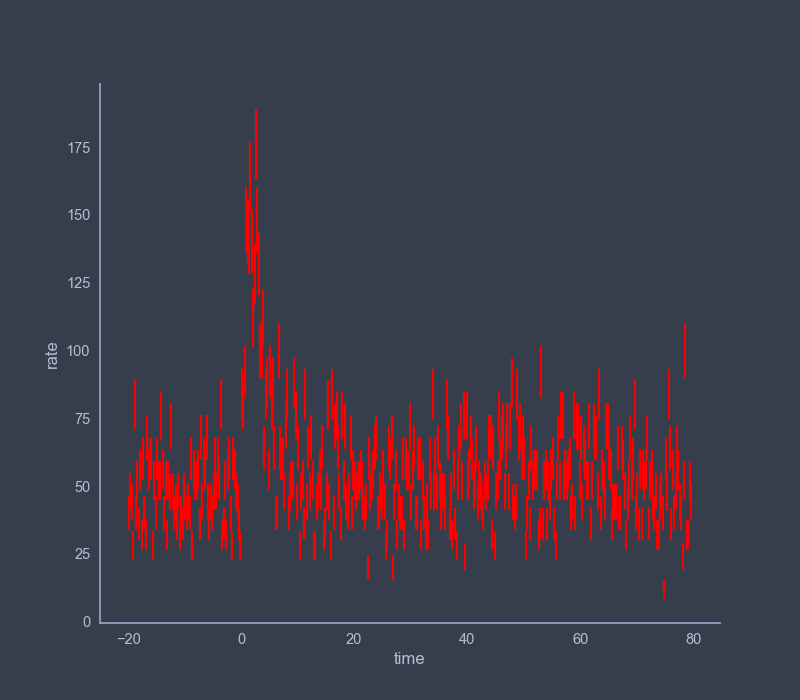

<IPython.core.display.Javascript object>


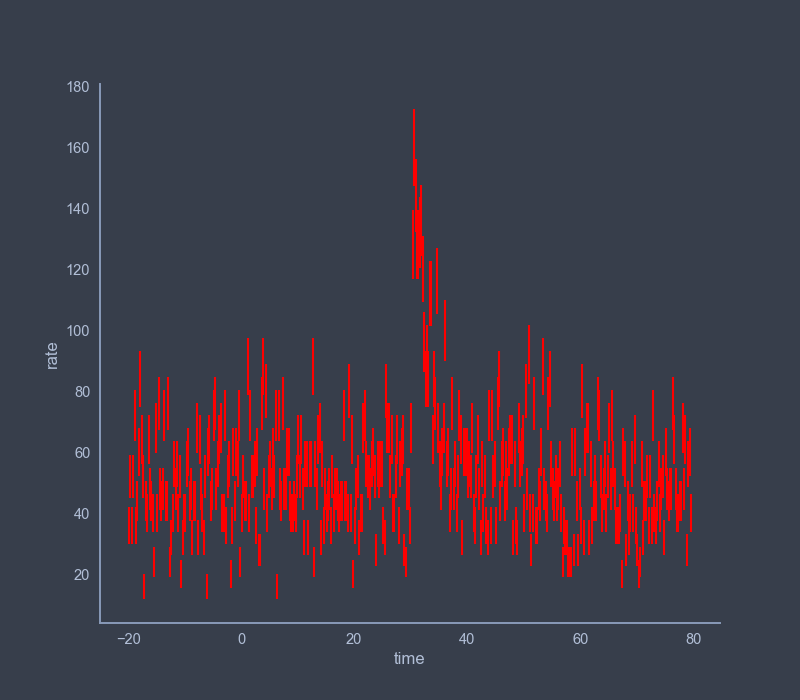

In [162]:
uni = Universe.from_yaml('template_config.yaml')
uni.explode_grb(tstart=-50,tstop=100)
for det, lc in uni.light_curves.items():

    lc.display(-20,80,.25,color='red')




In [6]:
uni._time_differences

0.
29.64412906


In [172]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-19,50,1.)
mid = np.mean([times[:-1],times[1:]], axis=0)

lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-20,80,1)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
k=50

N_model = 200

predict_time = np.linspace(-20,80,N_model)
omega=np.random.randn(k)

data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            k=k,
            bw=.2,
            omega=omega,
            N_model=N_model,
            predict_time=predict_time
           
           
           
           )

In [187]:
model = stan_utility.compile_model('rff.stan', model_name='rff')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rff_85f131f6e9db04b00af9041cd61aacad NOW.


In [ ]:
fit = model.sampling(warmup=1000,iter=1500,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=15, adapt_delta=.9)
                    

                    )

In [180]:
 model.sampling?

<IPython.core.display.Javascript object>


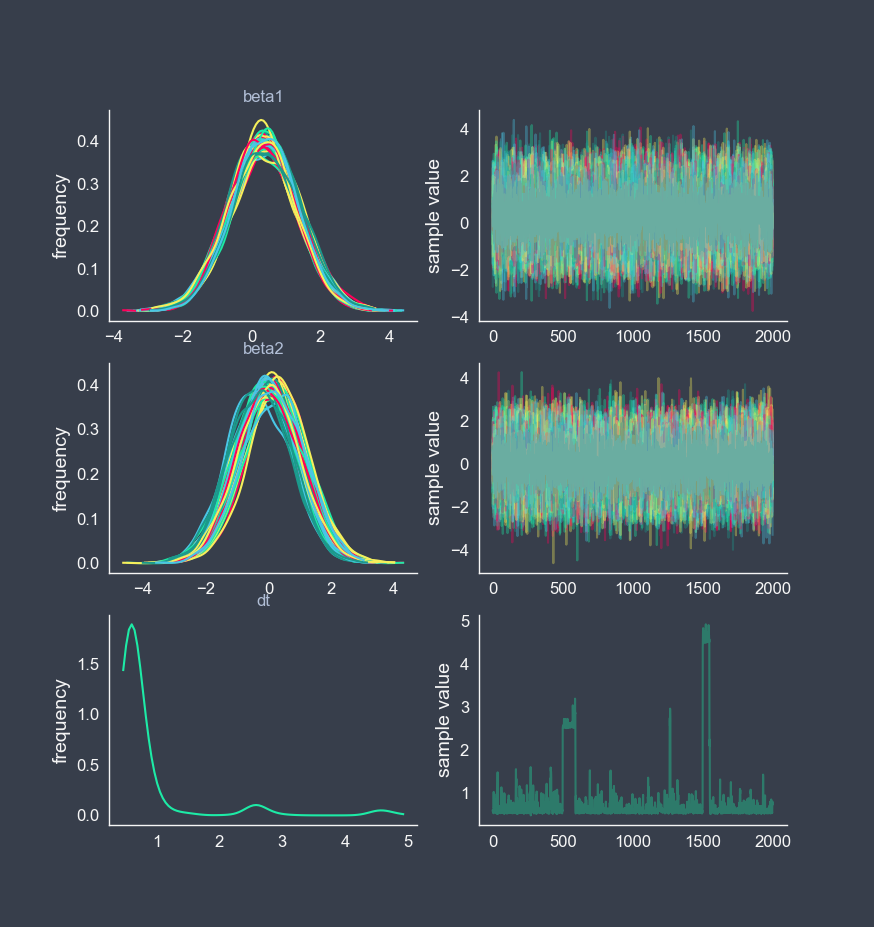

In [182]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt'
             
             ]);

<IPython.core.display.Javascript object>


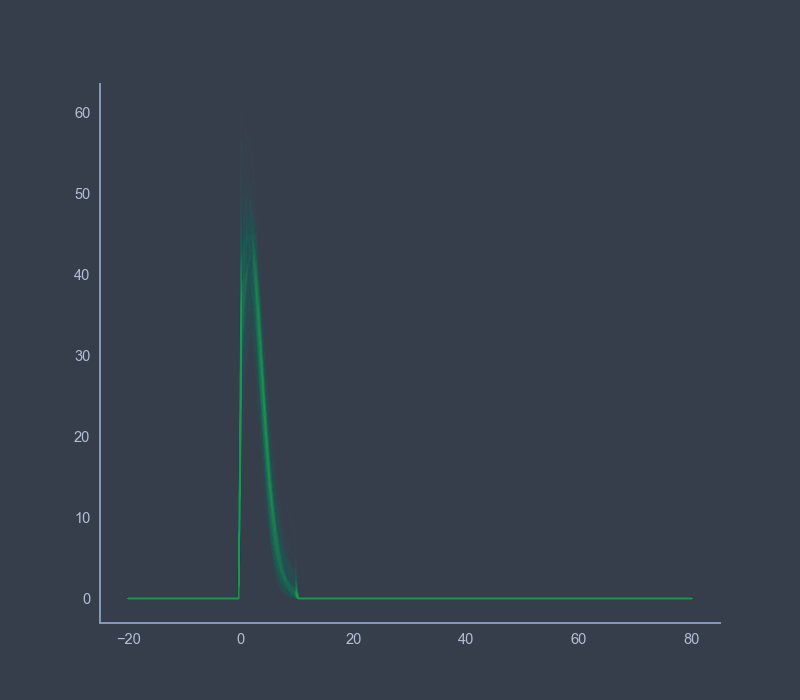

In [183]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::10]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


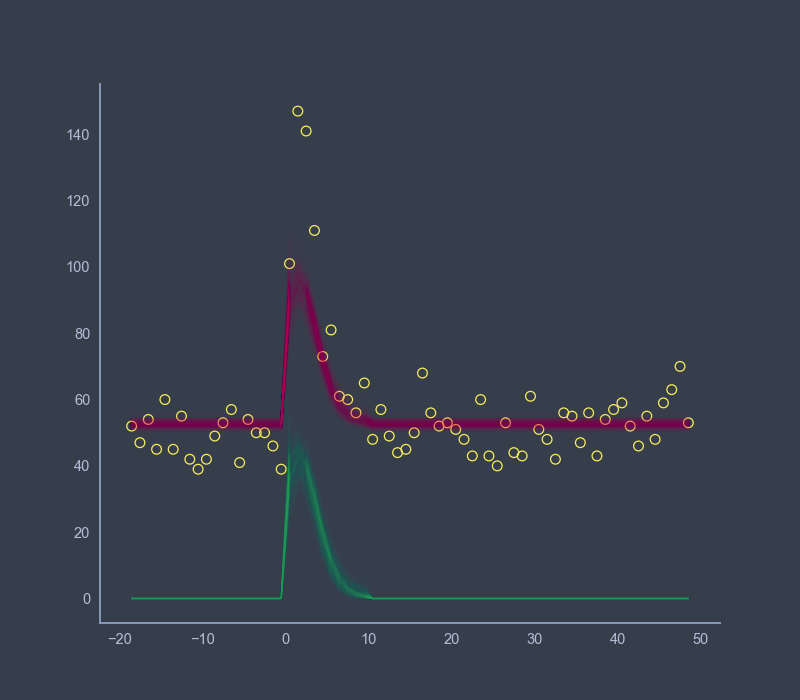

In [184]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, y + b, alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


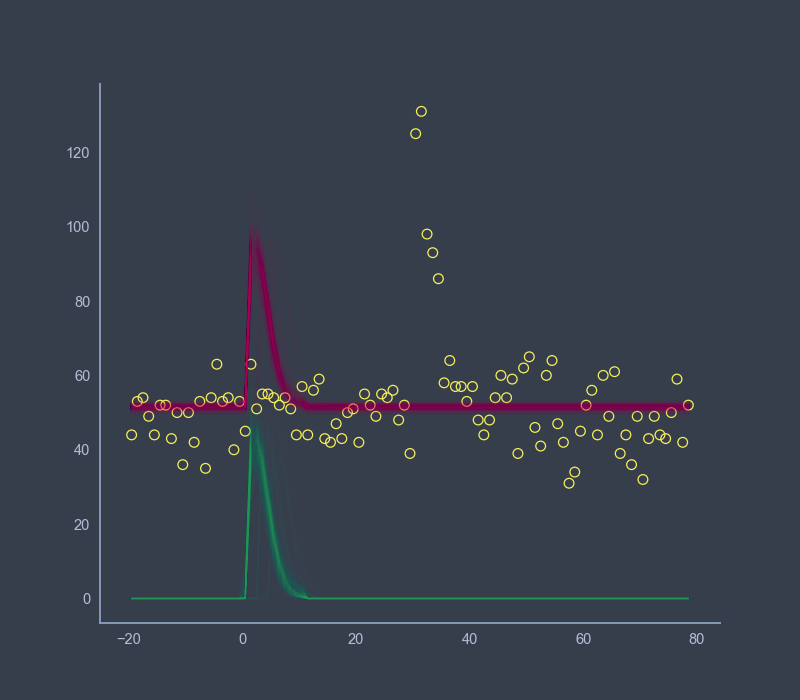

In [185]:
fig, ax = plt.subplots()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


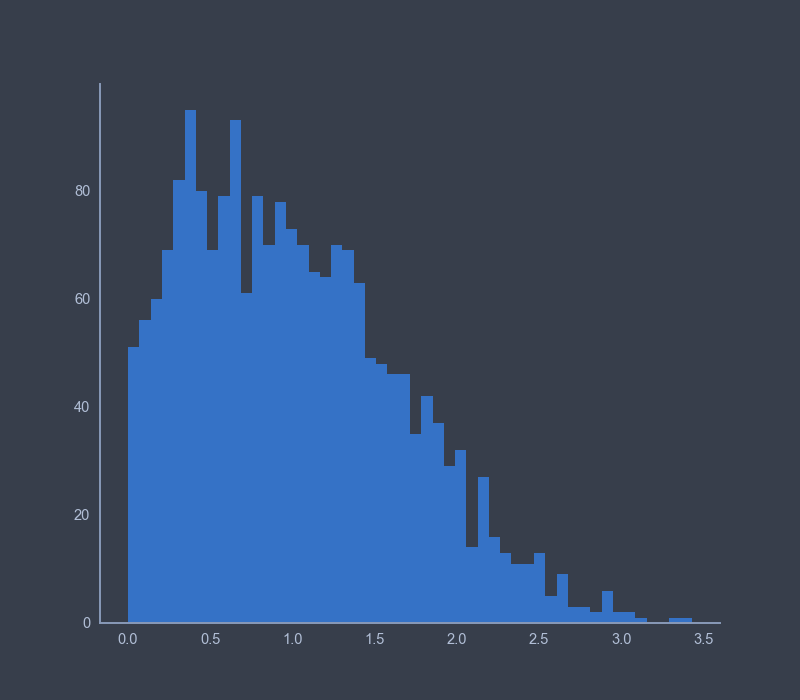

(array([51., 56., 60., 69., 82., 95., 80., 69., 79., 93., 61., 79., 70.,
        78., 73., 70., 65., 64., 70., 69., 63., 49., 48., 46., 46., 35.,
        42., 37., 29., 32., 14., 27., 16., 13., 11., 11., 13.,  5.,  9.,
         3.,  3.,  2.,  6.,  2.,  2.,  1.,  0.,  0.,  1.,  1.]),
 array([2.37461708e-03, 7.08961087e-02, 1.39417600e-01, 2.07939092e-01,
        2.76460584e-01, 3.44982075e-01, 4.13503567e-01, 4.82025058e-01,
        5.50546550e-01, 6.19068042e-01, 6.87589533e-01, 7.56111025e-01,
        8.24632517e-01, 8.93154008e-01, 9.61675500e-01, 1.03019699e+00,
        1.09871848e+00, 1.16723997e+00, 1.23576147e+00, 1.30428296e+00,
        1.37280445e+00, 1.44132594e+00, 1.50984743e+00, 1.57836892e+00,
        1.64689042e+00, 1.71541191e+00, 1.78393340e+00, 1.85245489e+00,
        1.92097638e+00, 1.98949787e+00, 2.05801937e+00, 2.12654086e+00,
        2.19506235e+00, 2.26358384e+00, 2.33210533e+00, 2.40062682e+00,
        2.46914832e+00, 2.53766981e+00, 2.60619130e+00, 2.67471279e+

In [142]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

<IPython.core.display.Javascript object>


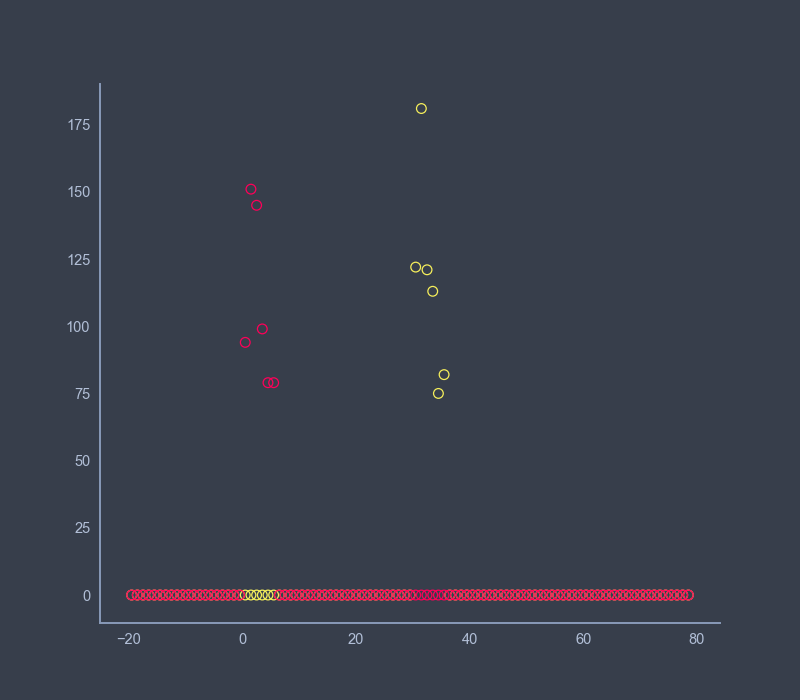

In [143]:
fig, ax = plt.subplots()

dt = 29.6


ax.scatter(mid2, counts2 * time_filter(mid2 -dt, 0, 6, 100), edgecolor=yellow, facecolor='none',lw=.9)
ax.scatter(mid, counts * time_filter(mid, 0, 6, 100), edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


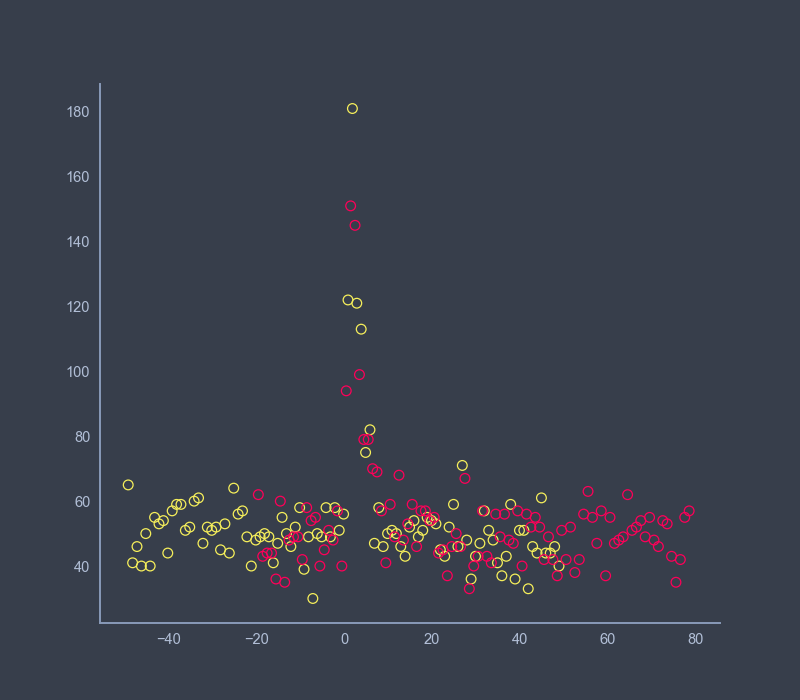

In [145]:
fig, ax = plt.subplots()

dt = 29.6


ax.scatter(mid2 -dt, counts2 , edgecolor=yellow, facecolor='none',lw=.9)
ax.scatter(mid, counts , edgecolor=red, facecolor='none',lw=.9)